In [1]:
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
f=h5py.File('/inputdata/cms-open-data-ml/big_train_test_data.h5','r')

In [3]:
for n in f.keys():
    print f[n]

<HDF5 dataset "X_0_test": shape (148244, 30, 30, 1), type "<f8">
<HDF5 dataset "X_0_train": shape (148244, 30, 30, 1), type "<f8">
<HDF5 dataset "X_1_test": shape (148244,), type "<f8">
<HDF5 dataset "X_1_train": shape (148244,), type "<f8">
<HDF5 dataset "X_2_test": shape (148244,), type "<f8">
<HDF5 dataset "X_2_train": shape (148244,), type "<f8">
<HDF5 dataset "encoded_Y_test": shape (148244,), type "<f8">
<HDF5 dataset "encoded_Y_train": shape (148244,), type "<f8">


In [4]:
encoded_Y_train = f['encoded_Y_train'].value
encoded_Y_test = f['encoded_Y_test'].value
X_train = [f['X_%d_train'%j].value for j in range(0,3)]
X_test = [f['X_%d_test'%j].value for j in range(0,3)]

In [5]:
# change pT range from 0 - 100, since we read in pthat 120-470
np.clip(X_train[0],0,100,out=X_train[0])
np.clip(X_test[0],0,100,out=X_test[0])
#scale
scaler = StandardScaler()
X_train[1] = scaler.fit_transform(X_train[1].reshape(-1,1))
X_test[1] = scaler.transform(X_test[1].reshape(-1,1))
#X_train[2] /= np.max(np.abs(2.5),axis=0)
#X_test[2] /= np.max(np.abs(2.5),axis=0)
# normalize jet eta 
X_train[2] /= 2.5
X_test[2] /= 2.5

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

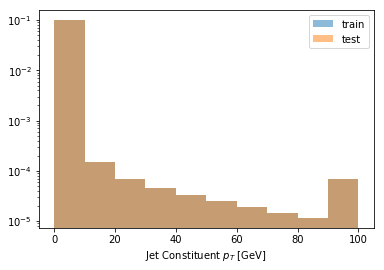

In [7]:
plt.hist(np.ravel(X_train[0]), label='train', alpha=0.5, normed=True)
plt.hist(np.ravel(X_test[0]), label='test', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel(r'Jet Constituent $p_{T}$ [GeV]')
plt.show()

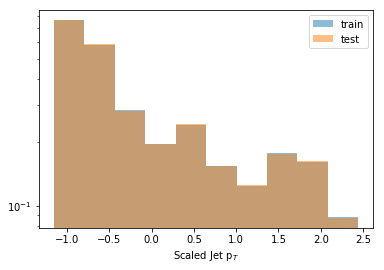

In [8]:
plt.hist(np.ravel(X_train[1]), label='train', alpha=0.5, normed=True)
plt.hist(np.ravel(X_test[1]), label='test', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel(r'Scaled Jet p$_{T}$')
plt.show()

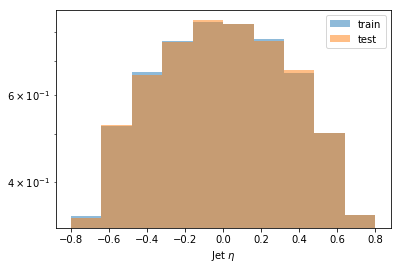

In [9]:
plt.hist(np.ravel(X_train[2]), label='train', alpha=0.5, normed=True)
plt.hist(np.ravel(X_test[2]), label='test', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel(r'Jet $\eta$')
plt.show()

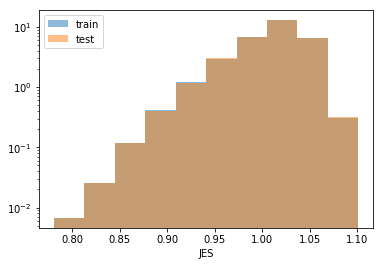

In [10]:
plt.hist(encoded_Y_train, label='train', alpha=0.5, normed=True)
plt.hist(encoded_Y_test, label='test', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel('JES')
plt.show()

In [11]:
import os, getpass
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES']='6'

from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Merge, merge

input_layer = Input(shape=(30,30,1))
layer = Convolution2D(20, 11,11, border_mode='same')(input_layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
#layer = Convolution2D(15, 9, 9, border_mode='same')(layer)
#layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(10, 7, 7, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Convolution2D(8, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(6, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(4, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Flatten()(layer)
# additional features input
jet_eta_ak7_input = Input(shape=(1,), name='jet_eta_ak7_input')
layer = merge([layer, jet_eta_ak7_input], mode='concat')
layer = Dense(20, activation='sigmoid')(layer)
layer = Dropout(0.08)(layer)
jet_pt_ak7_input = Input(shape=(1,), name='jet_pt_ak7_input')
layer = merge([layer, jet_pt_ak7_input], mode='concat')
layer = Dense(20, activation='softplus')(layer)
layer = Dropout(0.08)(layer)
#layer = Dropout(0.20)(layer)
# changing from softplus to tanh
#other activation option 'sigmoid' better for bounded problem
output_layer = Dense(1, activation='linear', name='main_output')(layer)
#output_layer = LeakyReLU('alpha=0.3')
#model.add(LeakyReLU(alpha=.001))
model = Model(input=[input_layer,jet_pt_ak7_input,jet_eta_ak7_input], output=output_layer)
#model = Model(input=input_layer, output=output_layer)
#model.compile(optimizer='adam', loss='kullback_leibler_divergence', metrics=['accuracy','precision','mse','msle'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy','precision','mse','msle'])
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 30, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 30, 20)    2440        input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 30, 30, 20)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 15, 15, 20)    0           activation_1[0][0]               
___________________________________________________________________________________________

In [12]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [13]:
#earlier it was 10, im changing it to 256, even though thats not an exact divisor of the # Jets 
bs=256

In [14]:
history = model.fit(X_train, encoded_Y_train, validation_data=(X_test, encoded_Y_test), 
                    nb_epoch=400, batch_size=bs, verbose=1, callbacks=[early_stopping])

Train on 148244 samples, validate on 148244 samples
Epoch 1/400
148244/148244 [==============================] - 11s - loss: 0.1121 - acc: 0.0000e+00 - precision: 0.9909 - mean_squared_error: 0.1121 - mean_squared_logarithmic_error: 0.0320 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 0.0015 - val_mean_squared_logarithmic_error: 3.7387e-04
Epoch 2/400
148244/148244 [==============================] - 9s - loss: 0.0224 - acc: 0.0000e+00 - precision: 0.9999 - mean_squared_error: 0.0224 - mean_squared_logarithmic_error: 0.0061 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 0.0012 - val_mean_squared_logarithmic_error: 3.1154e-04
Epoch 3/400
148244/148244 [==============================] - 9s - loss: 0.0135 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 0.0135 - mean_squared_logarithmic_error: 0.0036 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 0

148244/148244 [==============================] - 9s - loss: 6.4108e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 6.4108e-04 - mean_squared_logarithmic_error: 1.6163e-04 - val_loss: 6.3668e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 6.3668e-04 - val_mean_squared_logarithmic_error: 1.6086e-04
Epoch 25/400
148244/148244 [==============================] - 9s - loss: 6.2337e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 6.2337e-04 - mean_squared_logarithmic_error: 1.5705e-04 - val_loss: 6.0883e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 6.0883e-04 - val_mean_squared_logarithmic_error: 1.5360e-04
Epoch 26/400
148244/148244 [==============================] - 9s - loss: 5.9747e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 5.9747e-04 - mean_squared_logarithmic_error: 1.5037e-04 - val_loss: 6.1168e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 6.1168e-

148244/148244 [==============================] - 9s - loss: 3.7974e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.7974e-04 - mean_squared_logarithmic_error: 9.4969e-05 - val_loss: 4.6893e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 4.6893e-04 - val_mean_squared_logarithmic_error: 1.1817e-04
Epoch 48/400
148244/148244 [==============================] - 9s - loss: 3.7685e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.7685e-04 - mean_squared_logarithmic_error: 9.4229e-05 - val_loss: 4.3104e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 4.3104e-04 - val_mean_squared_logarithmic_error: 1.0811e-04
Epoch 49/400
148244/148244 [==============================] - 9s - loss: 3.7007e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.7007e-04 - mean_squared_logarithmic_error: 9.2525e-05 - val_loss: 4.3115e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 4.3115e-

148244/148244 [==============================] - 9s - loss: 3.1220e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.1220e-04 - mean_squared_logarithmic_error: 7.7974e-05 - val_loss: 3.9981e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.9981e-04 - val_mean_squared_logarithmic_error: 1.0011e-04
Epoch 71/400
148244/148244 [==============================] - 9s - loss: 3.0744e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.0744e-04 - mean_squared_logarithmic_error: 7.6781e-05 - val_loss: 3.7769e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.7769e-04 - val_mean_squared_logarithmic_error: 9.4802e-05
Epoch 72/400
148244/148244 [==============================] - 9s - loss: 3.0602e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.0602e-04 - mean_squared_logarithmic_error: 7.6450e-05 - val_loss: 4.2792e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 4.2792e-

148244/148244 [==============================] - 9s - loss: 2.7661e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7661e-04 - mean_squared_logarithmic_error: 6.9133e-05 - val_loss: 3.5534e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.5534e-04 - val_mean_squared_logarithmic_error: 8.9116e-05
Epoch 94/400
148244/148244 [==============================] - 9s - loss: 2.7772e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7772e-04 - mean_squared_logarithmic_error: 6.9392e-05 - val_loss: 3.5850e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.5850e-04 - val_mean_squared_logarithmic_error: 8.9711e-05
Epoch 95/400
148244/148244 [==============================] - 9s - loss: 2.7580e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7580e-04 - mean_squared_logarithmic_error: 6.8922e-05 - val_loss: 3.4632e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.4632e-

148244/148244 [==============================] - 9s - loss: 2.5871e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.5871e-04 - mean_squared_logarithmic_error: 6.4684e-05 - val_loss: 3.7469e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.7469e-04 - val_mean_squared_logarithmic_error: 9.4454e-05
Epoch 117/400
148244/148244 [==============================] - 9s - loss: 2.5902e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.5902e-04 - mean_squared_logarithmic_error: 6.4761e-05 - val_loss: 3.3180e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.3180e-04 - val_mean_squared_logarithmic_error: 8.3363e-05
Epoch 118/400
148244/148244 [==============================] - 9s - loss: 2.5400e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.5400e-04 - mean_squared_logarithmic_error: 6.3483e-05 - val_loss: 3.3266e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.3266

148244/148244 [==============================] - 9s - loss: 2.4309e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.4309e-04 - mean_squared_logarithmic_error: 6.0794e-05 - val_loss: 3.4308e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.4308e-04 - val_mean_squared_logarithmic_error: 8.6422e-05
Epoch 140/400
148244/148244 [==============================] - 9s - loss: 2.4295e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.4295e-04 - mean_squared_logarithmic_error: 6.0743e-05 - val_loss: 3.3361e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.3361e-04 - val_mean_squared_logarithmic_error: 8.3965e-05
Epoch 141/400
148244/148244 [==============================] - 9s - loss: 2.4219e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.4219e-04 - mean_squared_logarithmic_error: 6.0544e-05 - val_loss: 3.4498e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.4498

148244/148244 [==============================] - 9s - loss: 2.3294e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.3294e-04 - mean_squared_logarithmic_error: 5.8244e-05 - val_loss: 3.1476e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.1476e-04 - val_mean_squared_logarithmic_error: 7.9041e-05
Epoch 163/400
148244/148244 [==============================] - 9s - loss: 2.3502e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.3502e-04 - mean_squared_logarithmic_error: 5.8768e-05 - val_loss: 3.1922e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.1922e-04 - val_mean_squared_logarithmic_error: 8.0149e-05
Epoch 164/400
148244/148244 [==============================] - 9s - loss: 2.3322e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.3322e-04 - mean_squared_logarithmic_error: 5.8301e-05 - val_loss: 3.0776e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.0776

148244/148244 [==============================] - 9s - loss: 2.2637e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.2637e-04 - mean_squared_logarithmic_error: 5.6593e-05 - val_loss: 3.1425e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.1425e-04 - val_mean_squared_logarithmic_error: 7.8991e-05
Epoch 186/400
148244/148244 [==============================] - 9s - loss: 2.2874e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.2874e-04 - mean_squared_logarithmic_error: 5.7204e-05 - val_loss: 3.0520e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.0520e-04 - val_mean_squared_logarithmic_error: 7.6680e-05
Epoch 187/400
148244/148244 [==============================] - 9s - loss: 2.2643e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.2643e-04 - mean_squared_logarithmic_error: 5.6631e-05 - val_loss: 3.1039e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.1039

148244/148244 [==============================] - 9s - loss: 2.2357e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.2357e-04 - mean_squared_logarithmic_error: 5.5904e-05 - val_loss: 3.0440e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.0440e-04 - val_mean_squared_logarithmic_error: 7.6589e-05
Epoch 209/400
148244/148244 [==============================] - 9s - loss: 2.2237e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.2237e-04 - mean_squared_logarithmic_error: 5.5595e-05 - val_loss: 3.0613e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.0613e-04 - val_mean_squared_logarithmic_error: 7.6868e-05
Epoch 210/400
148244/148244 [==============================] - 9s - loss: 2.2097e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.2097e-04 - mean_squared_logarithmic_error: 5.5250e-05 - val_loss: 3.0480e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.0480

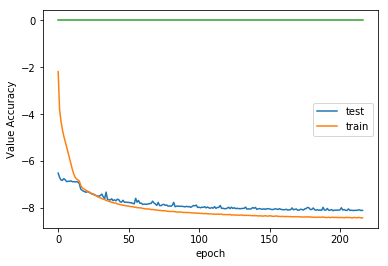

In [15]:
val_loss = np.asarray(history.history['val_loss'])
loss = np.asarray(history.history['loss'])
plt.plot(np.log(val_loss), label='test')
plt.plot(np.log(loss), label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
val_acc = np.asarray(history.history['val_acc'])
plt.plot(val_acc, label='')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Value Accuracy')

In [16]:
model_json = model.to_json()
with open("model_eta_dense_pt_dense_updatedJuly14.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_eta_dense_pt_dense_updatedJuly14.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
p_train = model.predict(X_train)
p_test = model.predict(X_test)

In [18]:
def plot_JEC( xyls ):
    plt.figure(figsize=(6,6))
    plt.grid()
    for X,Y,L in xyls:
        plt.scatter( X,Y, label=L, alpha=0.5 , marker='.')
    plt.xlim((0.8,1.2))
    plt.ylim((0.8,1.2))
    plt.hlines(1., 0.8,1.2)
    plt.vlines(1., 0.8,1.2)
    plt.xlabel( 'True JEC')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

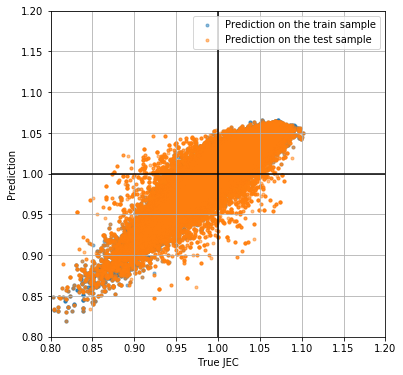

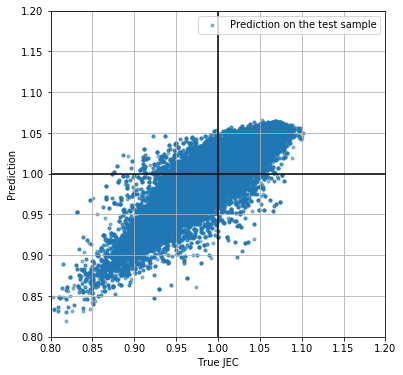

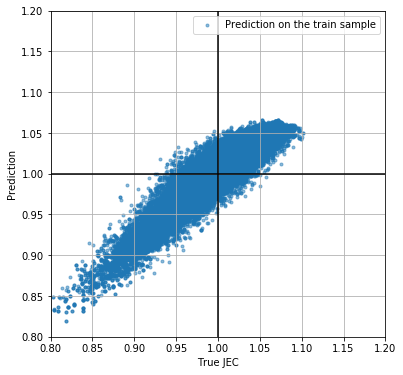

In [19]:
plot_JEC([
    (encoded_Y_train, p_train, 'Prediction on the train sample'),
    (encoded_Y_test, p_test, 'Prediction on the test sample')
])
plot_JEC([(encoded_Y_test, p_test, 'Prediction on the test sample')])
plot_JEC([(encoded_Y_train, p_train, 'Prediction on the train sample')])

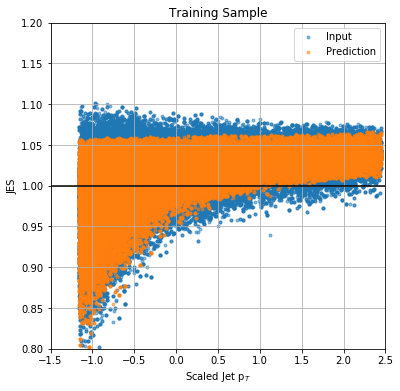

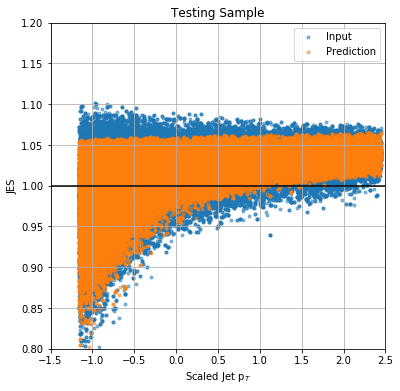

In [20]:
plt.figure(figsize=(6,6))
plt.grid()
plt.title('Training Sample')
plt.scatter( X_train[1], encoded_Y_train, label='Input ', alpha=0.5 , marker='.')
plt.scatter( X_train[1],p_train, label='Prediction', alpha=0.5 , marker='.')
plt.xlim((-1.5,2.5))
plt.ylim((0.8,1.2))
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel(r'Scaled Jet p$_{T}$')
plt.ylabel('JES')
plt.legend()
plt.show()
plt.figure(figsize=(6,6))
plt.grid()
plt.title('Testing Sample')
plt.scatter( X_test[1], encoded_Y_test, label='Input ', alpha=0.5 , marker='.')
plt.scatter( X_test[1],p_test, label='Prediction', alpha=0.5 , marker='.')
plt.xlim((-1.5,2.5))
plt.ylim((0.8,1.2))
plt.hlines(1., -1.5,2.5)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel(r'Scaled Jet p$_{T}$')
plt.ylabel('JES')
plt.legend()
plt.show()

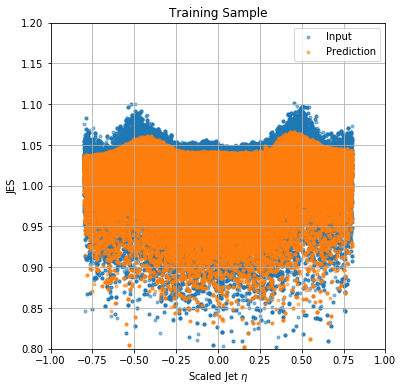

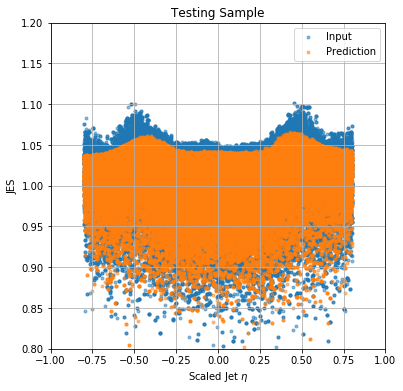

In [21]:
plt.figure(figsize=(6,6))
plt.grid()
plt.title('Training Sample')
plt.scatter( X_train[2], encoded_Y_train, label='Input ', alpha=0.5 , marker='.')
plt.scatter( X_train[2],p_train, label='Prediction', alpha=0.5 , marker='.')
plt.xlim((-1.,1.))
plt.ylim((0.8,1.2))
plt.hlines(5., -1.,1.)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel(r'Scaled Jet $\eta$')
plt.ylabel('JES')
plt.legend()
plt.show()
plt.figure(figsize=(6,6))
plt.grid()
plt.title('Testing Sample')
plt.scatter( X_test[2], encoded_Y_test, label='Input ', alpha=0.5 , marker='.')
plt.scatter( X_test[2],p_test, label='Prediction', alpha=0.5 , marker='.')
plt.xlim((-1.,1.))
plt.ylim((0.8,1.2))
plt.hlines(5., -1.,1.)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel(r'Scaled Jet $\eta$')
plt.ylabel('JES')
plt.legend()
plt.show()

In [22]:
encoded_Y_test=np.reshape(encoded_Y_test, (148244, ))
encoded_Y_train=np.reshape(encoded_Y_train, (148244, ))

In [23]:
p_test=np.reshape(p_test, (148244, ))
p_train=np.reshape(p_train, (148244, ))

In [24]:
p_test

array([ 0.96895951,  0.94687951,  0.96731263, ...,  1.03240561,
        0.96911621,  1.01256394], dtype=float32)

In [25]:
residual_test = p_test - encoded_Y_test
residual_train = p_train - encoded_Y_train


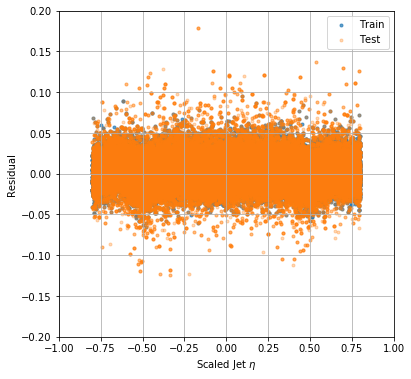

In [26]:
plt.figure(figsize=(6,6))
plt.grid()
plt.scatter( X_train[2], residual_train, label='Train', alpha=0.7 , marker='.')
plt.scatter( X_test[2], residual_test, label='Test', alpha=0.3 , marker='.')
plt.xlim((-1.,1.))
plt.ylim((-0.2,0.2))
plt.hlines(5., -1.,1.)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel(r'Scaled Jet $\eta$')
plt.ylabel('Residual')
plt.legend()
plt.show()

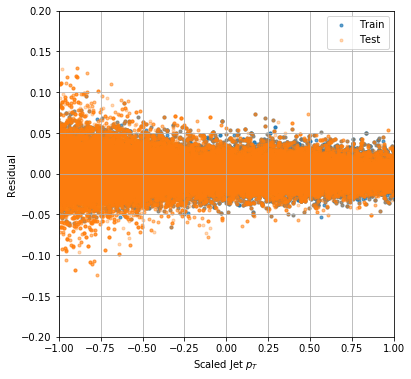

In [27]:
plt.figure(figsize=(6,6))
plt.grid()
plt.scatter( X_train[1], residual_train, label='Train', alpha=0.7 , marker='.')
plt.scatter( X_test[1], residual_test, label='Test', alpha=0.3 , marker='.')
plt.xlim((-1.,1.))
plt.ylim((-0.2,0.2))
plt.hlines(5., -1.,1.)
plt.vlines(3.0, 0.8,1.2)
plt.xlabel(r'Scaled Jet $p_{T}$')
plt.ylabel('Residual')
plt.legend()
plt.show()

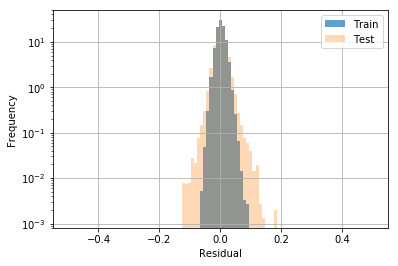

In [28]:
bins = np.linspace(-0.5, 0.5, 100)
plt.figure()
plt.grid()
plt.hist(residual_train, bins, label='Train', alpha=0.7, normed=True)
plt.hist(residual_test, bins, label='Test', alpha=0.3, normed=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.show()

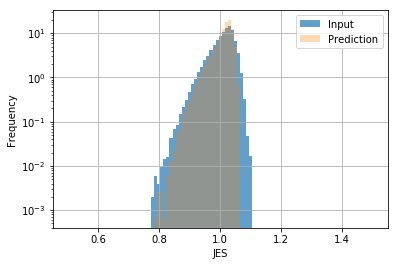

In [29]:
bins = np.linspace(0.5, 1.5, 100)
plt.figure()
plt.grid()
plt.hist(encoded_Y_test, bins, label='Input', alpha=0.7, normed=True)
plt.hist(p_test, bins, label='Prediction', alpha=0.3, normed=True)
plt.xlabel('JES')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.show()

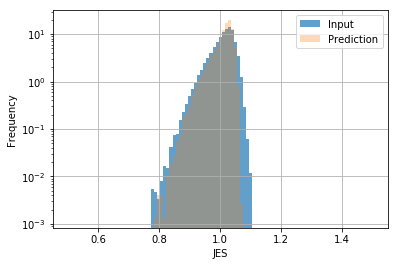

In [30]:
bins = np.linspace(0.5, 1.5, 100)
plt.figure()
plt.grid()
plt.hist(encoded_Y_train, bins, label='Input', alpha=0.7, normed=True)
plt.hist(p_train, bins, label='Prediction', alpha=0.3, normed=True)
plt.xlabel('JES')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.show()